## Project Title: "Logistics Process Simulation: Vaccine Clinic Model"


**Introduction:**

The whole idea of this homework 3 is to help the supply chain compaines who faced numerous challenges in optimizing their delivery operations, including route planning, resource allocation, and minimizing transit times by creating the simulation model called **package delivery networks**.

The basic outline of how you I can structure the code for a logistics network simulation for a package delivery company:

◍ **Entities:** In this problem entity is packages.

◍ **Events:**  The main key events in logistic network distribution could be package arrivals, truck departures/arrivals, package sorting/loading/unloading, and package deliveries.

◍ **Resources:** These could include trucks, sorting facilities, delivery staff, and distribution centers.

◍ **Stages:** Define the stages of the simulation, such as sorting, loading, transportation, unloading, and delivery.

◍ **Metrics:** Decide on the metrics I want to measure to evaluate the performance of the logistics network, such as package delivery times how it taking time while loading, sorting and unloading.

The Ultimate Goal of the problem - 

**Arrival -> Sorting -> Loading onto trucks -> Transportation -> Unloading Trucks -> Delivery -> Exit**

--Arrival: Packages arrive at the distribution center.

--Sorting: Packages are sorted based on their destination.

--Loading onto trucks: Sorted packages are loaded onto trucks for transportation.

--Transportation: Trucks depart from the distribution center to deliver packages to their destinations.

--Unloading: Trucks arrive at their destinations and packages are unloaded.

--Delivery: Packages are delivered to their final destinations.

--Exit: Packages have reached their final destinations and the process is complete.

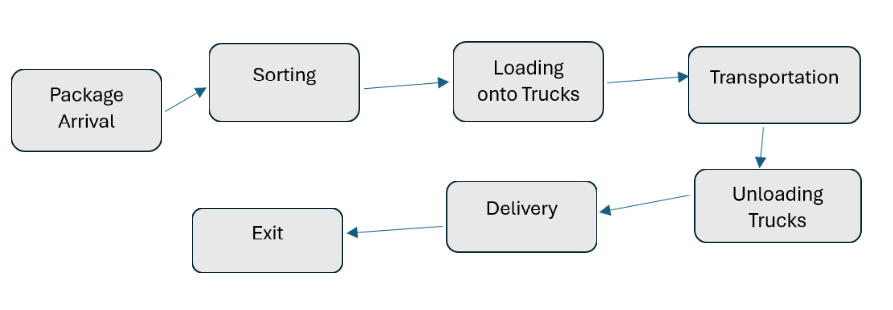

In [62]:
from IPython.display import Image

# Specify the path to your image file
image_path = 'Image/Model.png'  

# Display the image
Image(filename=image_path)

In [63]:
import simpy
from numpy.random import default_rng
import pandas as pd

**Intialization of the model** - Here this code snippet defines a simulation model for a logistics center using **SimPy** in Python. 

The LogisticsCenter class initializes the simulation environment and resources required for processing packages, with methods representing each stage of the logistics process. 

The get_package_delivered function orchestrates the entire process flow for each package, from sorting to delivery, while updating timestamps accordingly. 

In [64]:
class LogisticsCenter:
    def __init__(self, env, num_sorters, num_loaders, num_transporters, num_unloaders, rg):
        """
        Initialize the logistics center with resources and environment.

        Parameters:
        - env: SimPy environment object
        - num_sorters, num_loaders, num_transporters, num_unloaders: Number of each type of resource
        - rg: Random number generator from NumPy
        """
        self.env = env
        self.rg = rg
        
        # Create lists to hold timestamps dictionaries (one per package)
        self.timestamps_list = []
        
        # Create resources
        self.sorter = simpy.Resource(env, num_sorters)
        self.loader = simpy.Resource(env, num_loaders)
        self.transporter = simpy.Resource(env, num_transporters)
        self.unloader = simpy.Resource(env, num_unloaders)

    # Process methods for each step in the logistics process
    def sort_package(self, package):
        """
        Process for sorting a package.

        Parameters:
        - package: Package ID
        """
        yield self.env.timeout(self.rg.normal(1.0, 0.2))

    def load_package(self, package):
        """
        Process for loading a package onto a transporter.

        Parameters:
        - package: Package ID 
        """
        yield self.env.timeout(self.rg.exponential(2.0))

    def transport_package(self, package):
        """
        Process for transporting a package.

        Parameters:
        - package: Package ID 
        """
        yield self.env.timeout(self.rg.normal(4.0, 1.0))

    def unload_package(self, package):
        """
        Process for unloading a package.

        Parameters:
        - package: Package ID 
        """
        yield self.env.timeout(self.rg.exponential(1.5))

    def deliver_package(self, package):
        """
        Process for delivering a package.

        Parameters:
        - package: Package ID 
        """
        yield self.env.timeout(self.rg.normal(1.0, 0.2))

def get_package_delivered(env, package_id, logistics_center, rg):
    """
    Process function for a package delivery.

    Parameters:
    - env: SimPy environment object
    - package_id: ID 
    - logistics_center: LogisticsCenter object handling the delivery
    - rg: Random number generator from NumPy
    """
    arrival_time = env.now
    
    # Request and execute sorting process
    with logistics_center.sorter.request() as request:
        yield request
        got_sorter_ts = env.now
        yield env.process(logistics_center.sort_package(package_id))
        release_sorter_ts = env.now
    
    # Request and execute loading process
    with logistics_center.loader.request() as request:
        yield request
        got_loader_ts = env.now
        yield env.process(logistics_center.load_package(package_id))
        release_loader_ts = env.now

    # Request and execute transportation process
    with logistics_center.transporter.request() as request:
        yield request
        got_transporter_ts = env.now
        yield env.process(logistics_center.transport_package(package_id))
        release_transporter_ts = env.now

    # Request and execute unloading process
    with logistics_center.unloader.request() as request:
        yield request
        got_unloader_ts = env.now
        yield env.process(logistics_center.unload_package(package_id))
        release_unloader_ts = env.now

    # Execute delivery process
    yield env.process(logistics_center.deliver_package(package_id))
    delivery_time = env.now

    # Record timestamps for each step of the process
    timestamps = {'package_id': package_id,
                  'arrival_time': arrival_time,
                  'sorter_start_time': got_sorter_ts,
                  'sorter_end_time': release_sorter_ts,
                  'loader_start_time': got_loader_ts,
                  'loader_end_time': release_loader_ts,
                  'transporter_start_time': got_transporter_ts,
                  'transporter_end_time': release_transporter_ts,
                  'unloader_start_time': got_unloader_ts,
                  'unloader_end_time': release_unloader_ts,
                  'delivery_time': delivery_time}

    logistics_center.timestamps_list.append(timestamps)


This define function **run_logistics_center** code snippet -  the arrival and processing of packages at the logistics center, generating interarrival times from an exponential distribution. 

It sequentially processes each package, simulating sorting, loading, transporting, unloading, and delivery stages, until reaching the specified stop time or processing the maximum number of arrivals.

In [65]:
def run_logistics_center(env, logistics_center, mean_interarrival_time, rg, stoptime=simpy.core.Infinity, 
                         max_arrivals=simpy.core.Infinity):
    """
    Function to simulate the arrival and delivery of packages to a logistics center.

    Parameters:
    - env: SimPy environment object
    - logistics_center: LogisticsCenter object representing the facility
    - mean_interarrival_time: Mean time between package arrivals (exponential distribution parameter)
    - rg: Random number generator from NumPy
    - stoptime: Simulation end time
    - max_arrivals: Maximum number of packages to simulate

    Yields:
    - SimPy timeout events for package arrivals
    - Processes for delivering each package to the logistics center
    """
    package_id = 0

    # Loop until simulation time exceeds stoptime or maximum arrivals are reached
    while env.now < stoptime and package_id < max_arrivals:
        # Generate interarrival time using exponential distribution
        interarrival_time = rg.exponential(mean_interarrival_time)
        
        # Yield a timeout event representing the arrival of the next package
        yield env.timeout(interarrival_time)
        
        # Increment package ID for the next package
        package_id += 1
        
        # Start a new process for delivering the package to the logistics center
        env.process(get_package_delivered(env, package_id, logistics_center, rg))

The main function the baic model of simulation of a logistics center's operations, setting parameters such as mean interarrival time and resource capacities. It runs the simulation for a specified stop time, recording timestamps of each package's journey through the center. Finally, it saves the simulation results to a CSV file and prints the end time of the simulation.

In [66]:
def main():
    mean_interarrival_time = 5  # Mean interarrival time for packages (minutes)

    rg = default_rng(seed=4470)

    num_sorters = 2
    num_loaders = 3
    num_transporters = 4
    num_unloaders = 2

    stoptime =  40 # Simulation stop time (minutes)

    env = simpy.Environment()
    logistics_center = LogisticsCenter(env, num_sorters, num_loaders, num_transporters, num_unloaders, rg)

    env.process(run_logistics_center(env, logistics_center, mean_interarrival_time, rg, stoptime=stoptime))
    env.run()

    # Output log files
    logistics_log_df = pd.DataFrame(logistics_center.timestamps_list)
    logistics_log_df.to_csv('./output/logistics_log_df.csv', index=False)

    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return end_time

if __name__ == "__main__":
    main()

Simulation ended at time 53.66471101920433


**Interpretation:** 
The simulation ended at a time of approximately 52.65 minutes. This means that the entire simulated logistics operation, including the processing of packages from arrival to delivery, took about 52.65 minutes to complete.

Try two more scenario where I chose one is Peak Hour where we need more resources and Second one is Night shift where resources are low.

# Scenario 1 - Peak Hour Time

In [67]:
def main():
    mean_interarrival_time = 5  # Mean interarrival time for packages (minutes)

    rg = default_rng(seed=4470)

    num_sorters = 7
    num_loaders = 7
    num_transporters = 10
    num_unloaders = 7

    stoptime = 40  # Simulation stop time (minutes)

    env = simpy.Environment()
    logistics_center = LogisticsCenter(env, num_sorters, num_loaders, num_transporters, num_unloaders, rg)

    env.process(run_logistics_center(env, logistics_center, mean_interarrival_time, rg, stoptime=stoptime))
    env.run()

    # Output log files
    logistics_log_df = pd.DataFrame(logistics_center.timestamps_list)
    logistics_log_df.to_csv('./output/PeakHours_Scenario.csv', index=False)

    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return end_time

if __name__ == "__main__":
    main()

Simulation ended at time 52.654441318080195


**Interpretation**: Here I increase the number of sorters, transportes , loaders and unloaders and goal here to do the task within 40 min and result here I got the same which indicates it have improved efficiency but not enough to complete the simulation. 

# Scenario 2 - Night Shift Hours

In [68]:
def main():
    mean_interarrival_time = 5  # Mean interarrival time for packages (minutes)

    rg = default_rng(seed=4470)

    num_sorters = 3
    num_loaders = 2
    num_transporters = 4
    num_unloaders = 2

    stoptime = 40  # Simulation stop time (minutes)

    env = simpy.Environment()
    logistics_center = LogisticsCenter(env, num_sorters, num_loaders, num_transporters, num_unloaders, rg)

    env.process(run_logistics_center(env, logistics_center, mean_interarrival_time, rg, stoptime=stoptime))
    env.run()

    # Output log files
    logistics_log_df = pd.DataFrame(logistics_center.timestamps_list)
    logistics_log_df.to_csv('./output/NightHour_Scenario.csv', index=False)

    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return end_time

if __name__ == "__main__":
    main()

Simulation ended at time 57.85647759834649


**Interpretation**: Here I decearese the number of sortes, loaders, transporters,unloaders since it's night shift, I was expecting to increase stoptime but wanna to test with same stoptime found they are taking approx 58 mintues to do the same task.


**Comparsion and Key points for all scenarioes** - 

Basic Scenario (53.66 Miutes):

-Mderate resource allocation resulted in efficient operations.
-Blanced efficiency and resource utilization.

Peak Hours Scenario (52.65 Mintues):

-Rpresents peak demand hours with high resource utilization same results or close with basic scenario.

Night Hours Scenario (57.85 minutes):

-Smilar to the Basic Scenario but during off-peak hours.
-Slightly longer processing time suggests potential inefficiences.

**Post - Processing Time Stamp**

In [69]:
import pandas as pd

# Load the data from the CSV file
logistics_log_df = pd.read_csv('./output/logistics_log_df.csv')
logistics_log_df

,package_id,arrival_time,sorter_start_time,sorter_end_time,loader_start_time,loader_end_time,transporter_start_time,transporter_end_time,unloader_start_time,unloader_end_time,delivery_time
0,1,3.887459,3.887459,4.589318,4.589318,6.433862,6.433862,9.724406,9.724406,9.927852,11.209466
1,3,6.154300,6.154300,7.132207,7.132207,7.212821,7.212821,11.806101,11.806101,12.035561,13.293590
2,2,4.325589,4.325589,5.435875,5.435875,8.386933,8.386933,12.103029,12.103029,12.942534,14.121520
3,4,9.678621,9.678621,10.572367,10.572367,13.789913,13.789913,18.249101,18.249101,18.897966,20.214048
4,5,13.138966,13.138966,14.168787,14.168787,14.718889,14.718889,18.989320,18.989320,20.831632,22.104015
5,7,20.332696,20.332696,21.145756,21.145756,22.965559,22.965559,25.581380,25.581380,26.113206,26.994110
6,10,24.179232,24.179232,25.358880,25.358880,25.532438,25.532438,28.492904,28.492904,31.177482,32.117709
7,6,20.211492,20.211492,21.304563,21.304563,24.501291,24.501291,28.876228,31.177482,32.929909,33.799791
8,8,22.314033,22.314033,23.521205,23.521205,24.589930,24.589930,27.987500,27.987500,33.881421,34.982163
9,9,23.007057,23.007057,24.088817,24.088817,25.724567,25.724567,31.932284,32.929909,36.891684,38.129672


**Basic Scenario Statistics**

In [70]:
# Function to compute durations
def compute_durations(df):
    df['sorter_wait_time'] = df['sorter_start_time'] - df['arrival_time']
    df['sorting_time'] = df['sorter_end_time'] - df['sorter_start_time']
    df['loader_wait_time'] = df['loader_start_time'] - df['sorter_end_time']
    df['loading_time'] = df['loader_end_time'] - df['loader_start_time']
    df['transporter_wait_time'] = df['transporter_start_time'] - df['loader_end_time']
    df['transportation_time'] = df['transporter_end_time'] - df['transporter_start_time']
    df['unloader_wait_time'] = df['unloader_start_time'] - df['transporter_end_time']
    df['unloading_time'] = df['unloader_end_time'] - df['unloader_start_time']
    df['delivery_time'] = df['delivery_time'] - df['unloader_end_time']
    df['total_time'] = df['delivery_time'] + df['unloading_time'] + df['transportation_time'] + df['loading_time'] + df['sorting_time'] + df['sorter_wait_time'] + df['loader_wait_time'] + df['transporter_wait_time'] + df['unloader_wait_time']
    return df

# Compute durations
logistics_log_df = compute_durations(logistics_log_df)

# Display descriptive statistics
print(logistics_log_df.loc[:, ['sorter_wait_time', 'sorting_time',
                               'loader_wait_time', 'loading_time',
                               'transporter_wait_time', 'transportation_time',
                               'unloader_wait_time', 'unloading_time',
                               'delivery_time', 'total_time']].describe())

       sorter_wait_time  sorting_time  loader_wait_time  loading_time  \
count              16.0     16.000000         16.000000     16.000000   
mean                0.0      0.986188          0.082450      1.910358   
std                 0.0      0.170007          0.329801      1.525036   
min                 0.0      0.674386          0.000000      0.080615   
25%                 0.0      0.873575          0.000000      0.939070   
50%                 0.0      1.022965          0.000000      1.565217   
75%                 0.0      1.106593          0.000000      3.012476   
max                 0.0      1.207171          1.319202      5.937659   

       transporter_wait_time  transportation_time  unloader_wait_time  \
count                   16.0            16.000000           16.000000   
mean                     0.0             3.879564            0.278758   
std                      0.0             0.886733            0.653005   
min                      0.0             2.615821 

**Explanation** 
Minimal wait times across sorting, loading, and transportation stages indicate streamlined operations.
Average durations include 0.986 minutes for sorting, 1.910 minutes for loading, and 3.880 minutes for transportation per package.
 From arrival to delivery, packages take around 9.914 minutes on average, reflecting the total operational cycle efficiency.

In [71]:
import pandas as pd

# Load the data from the CSV file
logistics_log_df = pd.read_csv('./output/PeakHours_Scenario.csv')
logistics_log_df

# Function to compute durations
def compute_durations(df):
    df['sorter_wait_time'] = df['sorter_start_time'] - df['arrival_time']
    df['sorting_time'] = df['sorter_end_time'] - df['sorter_start_time']
    df['loader_wait_time'] = df['loader_start_time'] - df['sorter_end_time']
    df['loading_time'] = df['loader_end_time'] - df['loader_start_time']
    df['transporter_wait_time'] = df['transporter_start_time'] - df['loader_end_time']
    df['transportation_time'] = df['transporter_end_time'] - df['transporter_start_time']
    df['unloader_wait_time'] = df['unloader_start_time'] - df['transporter_end_time']
    df['unloading_time'] = df['unloader_end_time'] - df['unloader_start_time']
    df['delivery_time'] = df['delivery_time'] - df['unloader_end_time']
    df['total_time'] = df['delivery_time'] + df['unloading_time'] + df['transportation_time'] + df['loading_time'] + df['sorting_time'] + df['sorter_wait_time'] + df['loader_wait_time'] + df['transporter_wait_time'] + df['unloader_wait_time']
    return df

# Compute durations
logistics_log_df = compute_durations(logistics_log_df)

# Display descriptive statistics
print(logistics_log_df.loc[:, ['sorter_wait_time', 'sorting_time',
                               'loader_wait_time', 'loading_time',
                               'transporter_wait_time', 'transportation_time',
                               'unloader_wait_time', 'unloading_time',
                               'delivery_time', 'total_time']].describe())

       sorter_wait_time  sorting_time  loader_wait_time  loading_time  \
count              13.0     13.000000              13.0     13.000000   
mean                0.0      0.999976               0.0      1.596128   
std                 0.0      0.166905               0.0      1.113195   
min                 0.0      0.701858               0.0      0.080615   
25%                 0.0      0.893746               0.0      0.550101   
50%                 0.0      1.029821               0.0      1.635749   
75%                 0.0      1.110286               0.0      2.336570   
max                 0.0      1.207171               0.0      3.217545   

       transporter_wait_time  transportation_time  unloader_wait_time  \
count                   13.0            13.000000                13.0   
mean                     0.0             3.915265                 0.0   
std                      0.0             0.908619                 0.0   
min                      0.0             2.615821 

**Explanation:**
Average sorting time: 1.00 minutes
Average loading time: 1.60 minutes
Average total processing time per package: 9.42 minutes, highlighting operational high efficiency and variation.

In [72]:
import pandas as pd

# Load the data from the CSV file
logistics_log_df = pd.read_csv('./output/NightHour_Scenario.csv')
logistics_log_df

# Function to compute durations
def compute_durations(df):
    df['sorter_wait_time'] = df['sorter_start_time'] - df['arrival_time']
    df['sorting_time'] = df['sorter_end_time'] - df['sorter_start_time']
    df['loader_wait_time'] = df['loader_start_time'] - df['sorter_end_time']
    df['loading_time'] = df['loader_end_time'] - df['loader_start_time']
    df['transporter_wait_time'] = df['transporter_start_time'] - df['loader_end_time']
    df['transportation_time'] = df['transporter_end_time'] - df['transporter_start_time']
    df['unloader_wait_time'] = df['unloader_start_time'] - df['transporter_end_time']
    df['unloading_time'] = df['unloader_end_time'] - df['unloader_start_time']
    df['delivery_time'] = df['delivery_time'] - df['unloader_end_time']
    df['total_time'] = df['delivery_time'] + df['unloading_time'] + df['transportation_time'] + df['loading_time'] + df['sorting_time'] + df['sorter_wait_time'] + df['loader_wait_time'] + df['transporter_wait_time'] + df['unloader_wait_time']
    return df

# Compute durations
logistics_log_df = compute_durations(logistics_log_df)

# Display descriptive statistics
print(logistics_log_df.loc[:, ['sorter_wait_time', 'sorting_time',
                               'loader_wait_time', 'loading_time',
                               'transporter_wait_time', 'transportation_time',
                               'unloader_wait_time', 'unloading_time',
                               'delivery_time', 'total_time']].describe())

       sorter_wait_time  sorting_time  loader_wait_time  loading_time  \
count              15.0     15.000000         15.000000     15.000000   
mean                0.0      0.982124          0.446099      2.717512   
std                 0.0      0.177901          1.149810      2.686974   
min                 0.0      0.674386          0.000000      0.021213   
25%                 0.0      0.853403          0.000000      0.809414   
50%                 0.0      1.029821          0.000000      1.844545   
75%                 0.0      1.087416          0.000000      3.207136   
max                 0.0      1.282799          4.036956      8.374202   

       transporter_wait_time  transportation_time  unloader_wait_time  \
count                   15.0            15.000000           15.000000   
mean                     0.0             4.183393            0.004653   
std                      0.0             0.753158            0.018022   
min                      0.0             2.615821 

**Explanation** : The descriptive statistics summarize processing times in the logistics simulation: average sorting time is 0.98 minutes, loading averages 2.72 minutes, and total processing time per package averages 10.40 minutes, showcasing operational compartively lowefficiency and variability.

**Concluding Thoughts**: 

Overall, This logistics simulation model provides a structured approach to modeling and analyzing the operational efficiency of a logistics center. By using SimPy for discrete event simulation and incorporating random variates for realistic timing, it allows for robust experimentation and optimization of resource utilization and throughput. 

The combination of statistical analysis and visualization of performance metrics further enhances insights into system behavior, aiding in decision-making for process improvement and capacity planning in logistics operations.